In [110]:
from datascience import Table
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)
from matplotlib import patches
from ipywidgets import interact, interactive, fixed #pip installed ipywdigets in Terminal
import ipywidgets as widgets
import plotly.plotly as py
import plotly
plotly.tools.set_credentials_file(username='KevinMiao', api_key='FZpVgpkGX9s8HNG6MbHJ')
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn

# Let's clean it up 🧽

We pulled the Dataset downloaded from Kaggle (https://www.kaggle.com/jboysen/mri-and-alzheimers). The Datasets have been released as part of OASIS and open-source project aiming to clarify and encourage new discoveries in Alzheimers. The data has been collected by HHMI (Hughes Howard's Medical Institute, University of Washington and Harvard University)

### Cross-Sectional Data


**Cross-Section**, in other words, the plane that consists of the Sagital and Frontal axes.

**1** : We pulled the data. The columns `hand` and `delay` have been removed since the former column only contains right handed people and the latter column does not contribute to the classification or analysis of Alzheimers. Delay is only a technical note about when the data has been processed after the scan.

In [13]:
#pull data
cs = pd.read_csv('oasis_cross-sectional.csv')
cs = cs.drop(['Hand', 'Delay'], axis=1)
cs.head(5)

,ID,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS1_0001_MR1,F,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,OAS1_0002_MR1,F,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,OAS1_0003_MR1,F,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
3,OAS1_0004_MR1,M,28,NaN,NaN,NaN,NaN,1588,0.803,1.105
4,OAS1_0005_MR1,M,18,NaN,NaN,NaN,NaN,1737,0.848,1.010


## Cleaning

The Data have been cleaned, in other words, the redundant columns have been removed. Now we are replacing the `NaN` values by the median. This is very common practice and will help us to buffer for extreme variation, if applicable. The columns that have been cleaned are **`Educ`, `SES`, `MMSE` and `CDR`.** For more information, please read `Phase 0`. Additionally, we have made sure that all values are numerical now; this includes **`M/F`**.

In [14]:
#fill NA values w median values
cs["Educ"] = cs["Educ"].fillna(cs["Educ"].median())
cs["SES"] = cs["SES"].fillna(cs["SES"].median())
cs["MMSE"] = cs["MMSE"].fillna(cs["MMSE"].median())
cs["CDR"] = cs["CDR"].fillna(cs["CDR"].median())

#change categorical variable age to numercail
# M --> 0, F --> 1
cs["M/F"] = cs["M/F"].map(dict({"M": 0, "F": 1}))
cs.head()

,ID,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS1_0001_MR1,1,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,OAS1_0002_MR1,1,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,OAS1_0003_MR1,1,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
3,OAS1_0004_MR1,0,28,3.0,2.0,29.0,0.0,1588,0.803,1.105
4,OAS1_0005_MR1,0,18,3.0,2.0,29.0,0.0,1737,0.848,1.010


* `0` = Male
* `1` = Female

In [15]:
CrossSectionCleaned = cs.drop(columns = ['ID'])
CrossSectionCleaned.head()

,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,1,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,1,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,1,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
3,0,28,3.0,2.0,29.0,0.0,1588,0.803,1.105
4,0,18,3.0,2.0,29.0,0.0,1737,0.848,1.010


In [16]:
csgroup1 = cs.groupby("M/F").agg(np.mean)
csgroup1.head(5)

,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
M/F,,,,,,,,
0,48.148810,3.142857,2.172619,28.041667,0.157738,1592.410714,0.791452,1.109821
1,53.369403,3.067164,2.287313,27.902985,0.151119,1412.656716,0.791806,1.254731


### Bias?

There does not seem to be a bias between men and female (except for `age`). All variables seem to lie close to each other. The dataset, therefore, is representative and can be used to analyze the data.


In [17]:
print('There is data from ' + str(cs.shape[0]) + ' patients in this set.')

There is data from 436 patients in this set.


### Longitudinal Data


**Longitudinal**, in other words, data collected in the saggital plane.

In [18]:
#pulling the data from csv... drop hand as redundant
lg = pd.read_csv('oasis_longitudinal.csv')
lg = lg.drop('Hand', axis=1)
lg = lg.drop('MR Delay', axis=1)
lg = lg.drop('MRI ID', axis=1)

#going to fill in NA values with the median.. #of NA values too significant to get rid of 
lg["Educ"] = lg["EDUC"].fillna(lg["EDUC"].median())
lg["SES"] = lg["SES"].fillna(lg["SES"].median())
lg["MMSE"] = lg["MMSE"].fillna(lg["MMSE"].median())
lg["CDR"] = lg["CDR"].fillna(lg["CDR"].median())
#change gender M F values to integer values
# M --> 0, F --> 1
lg["M/F"] = lg["M/F"].map(dict({"M": 0, "F": 1}))

lg.head()

,Subject ID,Group,Visit,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Educ
0,OAS2_0001,Nondemented,1,0,87,14,2.0,27.0,0.0,1987,0.696,0.883,14
1,OAS2_0001,Nondemented,2,0,88,14,2.0,30.0,0.0,2004,0.681,0.876,14
2,OAS2_0002,Demented,1,0,75,12,2.0,23.0,0.5,1678,0.736,1.046,12
3,OAS2_0002,Demented,2,0,76,12,2.0,28.0,0.5,1738,0.713,1.010,12
4,OAS2_0002,Demented,3,0,80,12,2.0,22.0,0.5,1698,0.701,1.034,12


Same columns have been dropped and cleaned similar to what we did to the cross-sectional dataset. It is worht noting that this table is larger than the one before, since we have extra columns. In addition to this, this DataFrame has a time component to it (Visit) for the same people so we can track the development of the disease.

`Group` 
- `Demented` : Alzheimers
- `Nondemented` : No-Alzheimers
- `Converted` : Developed Alzheimers during the study

In [19]:
lggroup2 = lg.groupby("M/F").agg(np.mean)
lggroup2

,Visit,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Educ
M/F,,,,,,,,,,
0,1.956250,76.681250,14.893750,2.375000,26.637500,0.378125,1604.331250,0.718888,1.106094,14.893750
1,1.826291,77.262911,14.375587,2.483568,27.887324,0.225352,1400.840376,0.737592,1.262592,14.375587


Again, no selection bias since all values lie pretty close to each other irrespective of whether they are sick or not or any other variables. :)

In [20]:
lggroup1 = lg.groupby("Group").agg(np.mean)
lggroup1.head()

,Visit,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Educ
Group,,,,,,,,,,,
Converted,2.027027,0.648649,79.756757,15.459459,1.729730,28.675676,0.256757,1459.270270,0.723730,1.212405,15.459459
Demented,1.732877,0.410959,76.260274,13.671233,2.671233,24.575342,0.671233,1485.849315,0.716301,1.196890,13.671233
Nondemented,1.968421,0.678947,77.057895,15.142105,2.394737,29.226316,0.005263,1495.500000,0.740900,1.191063,15.142105


In [21]:
print('There is data from ' + str(lg.shape[0]) + ' patients in this set.')

There is data from 373 patients in this set.


# Trends

In [22]:
def standard_units(data):
    avg = np.average(data)
    stddev = np.std(data)
    return (data - avg) / stdev

In [23]:
def correlation(x, y):
    stdx = standard_units(x)
    stdy = standard_units(y)
    return np.mean(stdx * stdy)

## Age and CDR

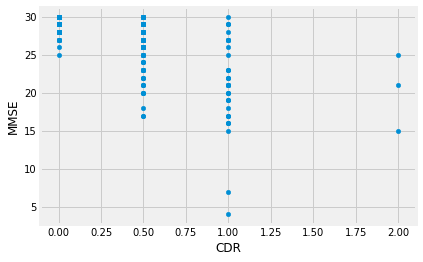

In [24]:
lg.plot.scatter(x='CDR', y = 'MMSE')

In [25]:
cs.head()

,ID,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS1_0001_MR1,1,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,OAS1_0002_MR1,1,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,OAS1_0003_MR1,1,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
3,OAS1_0004_MR1,0,28,3.0,2.0,29.0,0.0,1588,0.803,1.105
4,OAS1_0005_MR1,0,18,3.0,2.0,29.0,0.0,1737,0.848,1.010


# PCA : Cross-sectional

In [26]:
cs.describe()

,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
count,436.000000,436.000000,436.000000,436.000000,436.000000,436.00000,436.000000,436.000000,436.000000
mean,0.614679,51.357798,3.096330,2.243119,27.956422,0.15367,1481.919725,0.791670,1.198894
std,0.487230,25.269862,0.966037,0.825219,2.878446,0.31515,158.740866,0.059937,0.128682
min,0.000000,18.000000,1.000000,1.000000,14.000000,0.00000,1123.000000,0.644000,0.881000
25%,0.000000,23.000000,3.000000,2.000000,28.000000,0.00000,1367.750000,0.742750,1.111750
50%,1.000000,54.000000,3.000000,2.000000,29.000000,0.00000,1475.500000,0.809000,1.190000
75%,1.000000,74.000000,3.000000,2.000000,29.000000,0.00000,1579.250000,0.842000,1.284250
max,1.000000,96.000000,5.000000,5.000000,30.000000,2.00000,1992.000000,0.893000,1.563000


In [27]:
features = list(cs)
features.pop(6)
daf = cs.set_index('ID')
daf.head()

,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
ID,,,,,,,,,
OAS1_0001_MR1,1,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
OAS1_0002_MR1,1,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
OAS1_0003_MR1,1,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
OAS1_0004_MR1,0,28,3.0,2.0,29.0,0.0,1588,0.803,1.105
OAS1_0005_MR1,0,18,3.0,2.0,29.0,0.0,1737,0.848,1.010


In [28]:
from sklearn.preprocessing import StandardScaler
x = daf.iloc[:, [0,1,2,3,4,6,7,8]].values
y = daf.iloc[:, [5]]
X_std = StandardScaler().fit_transform(x) #standardized data!
X_std

array([[ 0.79174849,  0.89704535, -1.13617746, ..., -0.86983375,
        -0.81294769,  0.83328123],
       [ 0.79174849,  0.14429781,  0.93651448, ..., -2.11227567,
         0.30617709,  2.58378209],
       [ 0.79174849,  0.85742706,  0.93651448, ..., -0.17608445,
        -1.39756511,  0.06306086],
       ...,
       [-1.26302735, -1.1631058 , -0.09983149, ...,  0.61857384,
         1.07453142, -0.68381951],
       [ 0.79174849, -1.24234238, -0.09983149, ..., -1.38699231,
         1.1580482 ,  1.48680156],
       [ 0.79174849, -1.00463264, -0.09983149, ..., -1.25454927,
         0.70705761,  1.31564147]])

# Covariance Matrix

In [29]:
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)
#CovarianceMatrix

Covariance matrix 
[[ 1.00229885  0.10089006 -0.03826424  0.06787411 -0.02352838 -0.55299501
   0.00288095  0.54993415]
 [ 0.10089006  1.00229885  0.01066311  0.29867132 -0.38602492 -0.14130847
  -0.87610949  0.13783036]
 [-0.03826424  0.01066311  1.00229885 -0.64803974  0.2484457   0.09475561
   0.04293278 -0.07947059]
 [ 0.06787411  0.29867132 -0.64803974  1.00229885 -0.27294478 -0.16893676
  -0.26744255  0.15492772]
 [-0.02352838 -0.38602492  0.2484457  -0.27294478  1.00229885  0.04743885
   0.51839719 -0.04001703]
 [-0.55299501 -0.14130847  0.09475561 -0.16893676  0.04743885  1.00229885
  -0.00970712 -0.97790905]
 [ 0.00288095 -0.87610949  0.04293278 -0.26744255  0.51839719 -0.00970712
   1.00229885  0.01380295]
 [ 0.54993415  0.13783036 -0.07947059  0.15492772 -0.04001703 -0.97790905
   0.01380295  1.00229885]]


## Eigendecomposition

In [30]:
cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[-0.3169669  -0.35472917  0.11123191  0.86147784  0.12904103  0.04617502
  -0.01966582  0.00348349]
 [-0.39027651  0.35206113  0.3581489   0.02832108 -0.34746968 -0.10486529
   0.68038896  0.00185377]
 [ 0.23169947 -0.10627577  0.69484365 -0.08155452 -0.02709473  0.66129475
  -0.08636067 -0.00767725]
 [-0.34916311  0.18359042 -0.51611187  0.02701683 -0.34336285  0.67082569
  -0.09670339  0.00464787]
 [ 0.30586641 -0.33424857  0.00500982  0.10991305 -0.85169394 -0.20386276
  -0.12517899 -0.002301  ]
 [ 0.42660873  0.43754387 -0.06373909  0.34028922  0.00584084  0.04420329
   0.04555416  0.70896946]
 [ 0.34439513 -0.45509079 -0.31713203 -0.03646379  0.13608589  0.23282553
   0.70686102  0.00156252]
 [-0.42125934 -0.4415267   0.07427763 -0.3470815  -0.00670886 -0.04279718
  -0.04976895  0.70516555]]

Eigenvalues 
[2.72399823 2.20369394 1.44802584 0.56824281 0.66276907 0.29055859
 0.09686119 0.02424112]


In [31]:
u,s,v = np.linalg.svd(X_std.T)
u

array([[-0.3169669 ,  0.35472917,  0.11123191, -0.12904103, -0.86147784,
        -0.04617502,  0.01966582,  0.00348349],
       [-0.39027651, -0.35206113,  0.3581489 ,  0.34746968, -0.02832108,
         0.10486529, -0.68038896,  0.00185377],
       [ 0.23169947,  0.10627577,  0.69484365,  0.02709473,  0.08155452,
        -0.66129475,  0.08636067, -0.00767725],
       [-0.34916311, -0.18359042, -0.51611187,  0.34336285, -0.02701683,
        -0.67082569,  0.09670339,  0.00464787],
       [ 0.30586641,  0.33424857,  0.00500982,  0.85169394, -0.10991305,
         0.20386276,  0.12517899, -0.002301  ],
       [ 0.42660873, -0.43754387, -0.06373909, -0.00584084, -0.34028922,
        -0.04420329, -0.04555416,  0.70896946],
       [ 0.34439513,  0.45509079, -0.31713203, -0.13608589,  0.03646379,
        -0.23282553, -0.70686102,  0.00156252],
       [-0.42125934,  0.4415267 ,  0.07427763,  0.00670886,  0.3470815 ,
         0.04279718,  0.04976895,  0.70516555]])

In [32]:
for ev in eig_vecs:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')

Everything ok!


In [33]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
2.7239982318192277
2.2036939419586097
1.4480258373977113
0.6627690731084468
0.5682428144217616
0.29055859201364154
0.09686119362586446
0.02424112025243185


In [34]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

trace1 = dict(
    type='bar',
    x=['PC %s' %i for i in range(1,5)],
    y=var_exp,
    name='Individual'
)

trace2 = dict(
    type='scatter',
    x=['PC %s' %i for i in range(1,5)], 
    y=cum_var_exp,
    name='Cumulative'
)

data = [trace1, trace2]

layout=dict(
    title='Explained variance by different principal components',
    yaxis=dict(
        title='Explained variance in percent'
    ),
    annotations=list([
        dict(
            x=1.16,
            y=1.05,
            xref='paper',
            yref='paper',
            text='Explained Variance',
            showarrow=False,
        )
    ])
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='selecting-principal-components')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~KevinMiao/0 or inside your plot.ly account where it is named 'selecting-principal-components'


In [132]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
Table().with_column('Variance Explained (%)'
                    , var_exp).with_column('Principal Component #', np.arange(1, 9))

Variance Explained (%),Principal Component #
33.9719,1
27.483,2
18.0588,3
8.26561,4
7.08674,5
3.62365,6
1.20799,7
0.302319,8


In [133]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(8,1), 
                      eig_pairs[1][1].reshape(8,1)))

print('Matrix W:\n', matrix_w)

Matrix W:
 [[-0.3169669  -0.35472917]
 [-0.39027651  0.35206113]
 [ 0.23169947 -0.10627577]
 [-0.34916311  0.18359042]
 [ 0.30586641 -0.33424857]
 [ 0.42660873  0.43754387]
 [ 0.34439513 -0.45509079]
 [-0.42125934 -0.4415267 ]]


In [36]:
Y = X_std.dot(matrix_w)
Y #2-dimensional to make it more visually interesting!

array([[-2.0759838 , -0.17557517],
       [-1.33678967, -2.93214484],
       [-1.37396347,  0.73238161],
       [ 1.61069307,  0.48651234],
       [ 2.73642243,  0.74246137],
       [-1.33065111, -3.53979993],
       [ 1.51010294, -0.19367437],
       [ 0.88995976, -1.09660172],
       [ 1.0642932 ,  1.90054638],
       [-0.61976055, -1.71256088],
       [ 1.73367694,  0.14496439],
       [ 0.38156544,  1.48440692],
       [ 1.08317686, -1.10265351],
       [ 0.75372853,  2.76120045],
       [-1.46318731,  1.92289759],
       [ 2.44858796,  0.57503654],
       [ 0.77857227,  1.36801951],
       [ 0.25903925,  0.44753682],
       [-0.39254376, -1.51870266],
       [-0.15464699,  2.69675235],
       [-2.39811336,  1.1722122 ],
       [-1.51708582,  1.59843639],
       [-0.41332666, -3.00749072],
       [-0.38186505, -2.57201378],
       [-1.35052889, -2.60985322],
       [-2.33279947,  1.10112942],
       [ 2.3511315 ,  0.29786741],
       [-1.53939243, -0.17370522],
       [-2.58974622,

In [48]:
PCCS = pd.DataFrame(Y, columns=['PC1', 'PC2'])
PCCS.head()

,PC1,PC2
0,-2.075984,-0.175575
1,-1.336790,-2.932145
2,-1.373963,0.732382
3,1.610693,0.486512
4,2.736422,0.742461


In [51]:
joinedcs = PCCS.join(cs)
joinedcs.head()

,PC1,PC2,ID,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,-2.075984,-0.175575,OAS1_0001_MR1,1,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,-1.336790,-2.932145,OAS1_0002_MR1,1,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,-1.373963,0.732382,OAS1_0003_MR1,1,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
3,1.610693,0.486512,OAS1_0004_MR1,0,28,3.0,2.0,29.0,0.0,1588,0.803,1.105
4,2.736422,0.742461,OAS1_0005_MR1,0,18,3.0,2.0,29.0,0.0,1737,0.848,1.010


In [58]:
tabularcs = joinedcs[['PC1', 'PC2', 'CDR']]
tabularcs.head()

,PC1,PC2,CDR
0,-2.075984,-0.175575,0.0
1,-1.336790,-2.932145,0.0
2,-1.373963,0.732382,0.5
3,1.610693,0.486512,0.0
4,2.736422,0.742461,0.0


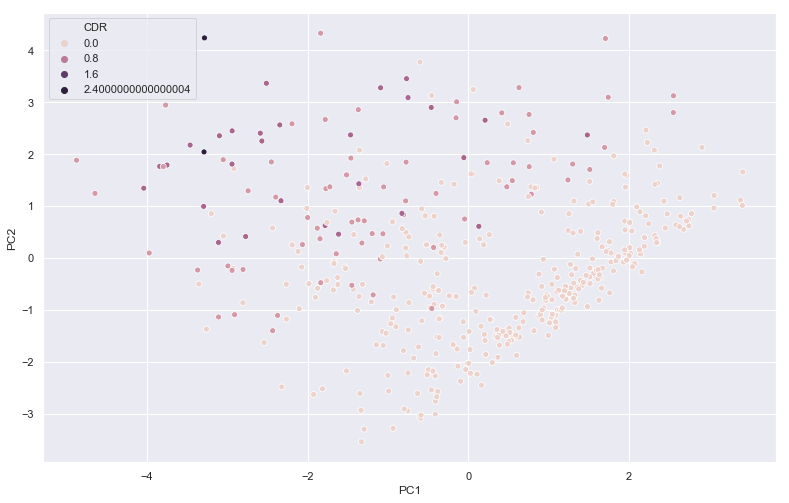

In [75]:
seaborn.set(rc={'figure.figsize':(11.7,8.27)})
ax = seaborn.scatterplot(x="PC1", y="PC2", hue = 'CDR', data=tabularcs)

# PCA : LTD

In [119]:
lg.head()

,Subject ID,Group,Visit,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Educ
0,OAS2_0001,Nondemented,1,0,87,14,2.0,27.0,0.0,1987,0.696,0.883,14
1,OAS2_0001,Nondemented,2,0,88,14,2.0,30.0,0.0,2004,0.681,0.876,14
2,OAS2_0002,Demented,1,0,75,12,2.0,23.0,0.5,1678,0.736,1.046,12
3,OAS2_0002,Demented,2,0,76,12,2.0,28.0,0.5,1738,0.713,1.010,12
4,OAS2_0002,Demented,3,0,80,12,2.0,22.0,0.5,1698,0.701,1.034,12


In [124]:
lg.describe()

,Visit,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Educ
count,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000
mean,1.882038,0.571046,77.013405,14.597855,2.436997,27.351206,0.290885,1488.128686,0.729568,1.195461,14.597855
std,0.922843,0.495592,7.640957,2.876339,1.109307,3.675329,0.374557,176.139286,0.037135,0.138092,2.876339
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000,6.000000
25%,1.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1357.000000,0.700000,1.099000,12.000000
50%,2.000000,1.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1470.000000,0.729000,1.194000,15.000000
75%,2.000000,1.000000,82.000000,16.000000,3.000000,30.000000,0.500000,1597.000000,0.756000,1.293000,16.000000
max,5.000000,1.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000,23.000000


In [126]:
features = list(lg)
features.pop(6)
longi = lg.set_index('Subject ID').drop(columns = ['Group', 'Visit', 'Educ'])
longi.head()

,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
Subject ID,,,,,,,,,
OAS2_0001,0,87,14,2.0,27.0,0.0,1987,0.696,0.883
OAS2_0001,0,88,14,2.0,30.0,0.0,2004,0.681,0.876
OAS2_0002,0,75,12,2.0,23.0,0.5,1678,0.736,1.046
OAS2_0002,0,76,12,2.0,28.0,0.5,1738,0.713,1.010
OAS2_0002,0,80,12,2.0,22.0,0.5,1698,0.701,1.034


In [130]:
from sklearn.preprocessing import StandardScaler
lx = longi.iloc[:, [0,1,2,3,4,6,7,8]].values
ly = longi.iloc[:, [5]]
lX_std = StandardScaler().fit_transform(x) #standardized data!
lX_std

array([[-1.15379808,  1.30873772, -0.20813199, ...,  2.83605891,
        -0.90516867, -2.2657425 ],
       [-1.15379808,  1.43978716, -0.20813199, ...,  2.93270307,
        -1.30964265, -2.31650145],
       [-1.15379808, -0.26385558, -0.90439416, ...,  1.07940909,
         0.17342861, -1.08378418],
       ...,
       [ 0.86670278, -2.09854775, -0.55626308, ..., -0.96148827,
         1.92614919,  0.98283006],
       [ 0.86670278, -1.83644887, -0.55626308, ..., -0.91600866,
         1.79132453,  0.92481984],
       [ 0.86670278, -1.57434999, -0.55626308, ..., -0.88189896,
         1.92614919,  0.88131217]])

# COVARIANCE MATRIX

In [131]:
lmean_vec = np.mean(lX_std, axis=0)
lcov_mat = (X_std - lmean_vec).T.dot((lX_std - mean_vec)) / (lX_std.shape[0]-1)
print('Covariance matrix \n%s' %lcov_mat)
#CovarianceMatrix

Covariance matrix 
[[ 1.00268817  0.03782786 -0.0895192   0.048634    0.16898277 -0.57408805
   0.25028903  0.56315721]
 [ 0.03782786  1.00268817 -0.02796079 -0.04553242  0.05540365  0.04246226
  -0.51975265 -0.03516099]
 [-0.0895192  -0.02796079  1.00268817 -0.69307976  0.19267487  0.25770596
  -0.01223243 -0.24240188]
 [ 0.048634   -0.04553242 -0.69307976  1.00268817 -0.14031873 -0.24969899
   0.09260902  0.24147833]
 [ 0.16898277  0.05540365  0.19267487 -0.14031873  1.00268817 -0.03633111
   0.34310855  0.04508105]
 [-0.57408805  0.04246226  0.25770596 -0.24969899 -0.03633111  1.00268817
  -0.21068667 -0.99153479]
 [ 0.25028903 -0.51975265 -0.01223243  0.09260902  0.34310855 -0.21068667
   1.00268817  0.21405   ]
 [ 0.56315721 -0.03516099 -0.24240188  0.24147833  0.04508105 -0.99153479
   0.21405     1.00268817]]


In [34]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

trace1 = dict(
    type='bar',
    x=['PC %s' %i for i in range(1,5)],
    y=var_exp,
    name='Individual'
)

trace2 = dict(
    type='scatter',
    x=['PC %s' %i for i in range(1,5)], 
    y=cum_var_exp,
    name='Cumulative'
)

data = [trace1, trace2]

layout=dict(
    title='Explained variance by different principal components',
    yaxis=dict(
        title='Explained variance in percent'
    ),
    annotations=list([
        dict(
            x=1.16,
            y=1.05,
            xref='paper',
            yref='paper',
            text='Explained Variance',
            showarrow=False,
        )
    ])
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='selecting-principal-components')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~KevinMiao/0 or inside your plot.ly account where it is named 'selecting-principal-components'


In [116]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
Table().with_column('Variance Explained (%)'
                    , var_exp).with_column('Principal Component #', np.arange(1, 9))

Variance Explained (%),Principal Component #
33.9719,1
27.483,2
18.0588,3
8.26561,4
7.08674,5
3.62365,6
1.20799,7
0.302319,8


In [35]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(8,1), 
                      eig_pairs[1][1].reshape(8,1)))

print('Matrix W:\n', matrix_w)

Matrix W:
 [[-0.3169669  -0.35472917]
 [-0.39027651  0.35206113]
 [ 0.23169947 -0.10627577]
 [-0.34916311  0.18359042]
 [ 0.30586641 -0.33424857]
 [ 0.42660873  0.43754387]
 [ 0.34439513 -0.45509079]
 [-0.42125934 -0.4415267 ]]


In [36]:
Y = X_std.dot(matrix_w)
Y #2-dimensional to make it more visually interesting!

array([[-2.0759838 , -0.17557517],
       [-1.33678967, -2.93214484],
       [-1.37396347,  0.73238161],
       [ 1.61069307,  0.48651234],
       [ 2.73642243,  0.74246137],
       [-1.33065111, -3.53979993],
       [ 1.51010294, -0.19367437],
       [ 0.88995976, -1.09660172],
       [ 1.0642932 ,  1.90054638],
       [-0.61976055, -1.71256088],
       [ 1.73367694,  0.14496439],
       [ 0.38156544,  1.48440692],
       [ 1.08317686, -1.10265351],
       [ 0.75372853,  2.76120045],
       [-1.46318731,  1.92289759],
       [ 2.44858796,  0.57503654],
       [ 0.77857227,  1.36801951],
       [ 0.25903925,  0.44753682],
       [-0.39254376, -1.51870266],
       [-0.15464699,  2.69675235],
       [-2.39811336,  1.1722122 ],
       [-1.51708582,  1.59843639],
       [-0.41332666, -3.00749072],
       [-0.38186505, -2.57201378],
       [-1.35052889, -2.60985322],
       [-2.33279947,  1.10112942],
       [ 2.3511315 ,  0.29786741],
       [-1.53939243, -0.17370522],
       [-2.58974622,

In [48]:
PCCS = pd.DataFrame(Y, columns=['PC1', 'PC2'])
PCCS.head()

,PC1,PC2
0,-2.075984,-0.175575
1,-1.336790,-2.932145
2,-1.373963,0.732382
3,1.610693,0.486512
4,2.736422,0.742461


In [51]:
joinedcs = PCCS.join(cs)
joinedcs.head()

,PC1,PC2,ID,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,-2.075984,-0.175575,OAS1_0001_MR1,1,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,-1.336790,-2.932145,OAS1_0002_MR1,1,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,-1.373963,0.732382,OAS1_0003_MR1,1,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
3,1.610693,0.486512,OAS1_0004_MR1,0,28,3.0,2.0,29.0,0.0,1588,0.803,1.105
4,2.736422,0.742461,OAS1_0005_MR1,0,18,3.0,2.0,29.0,0.0,1737,0.848,1.010


In [58]:
tabularcs = joinedcs[['PC1', 'PC2', 'CDR']]
tabularcs.head()

,PC1,PC2,CDR
0,-2.075984,-0.175575,0.0
1,-1.336790,-2.932145,0.0
2,-1.373963,0.732382,0.5
3,1.610693,0.486512,0.0
4,2.736422,0.742461,0.0


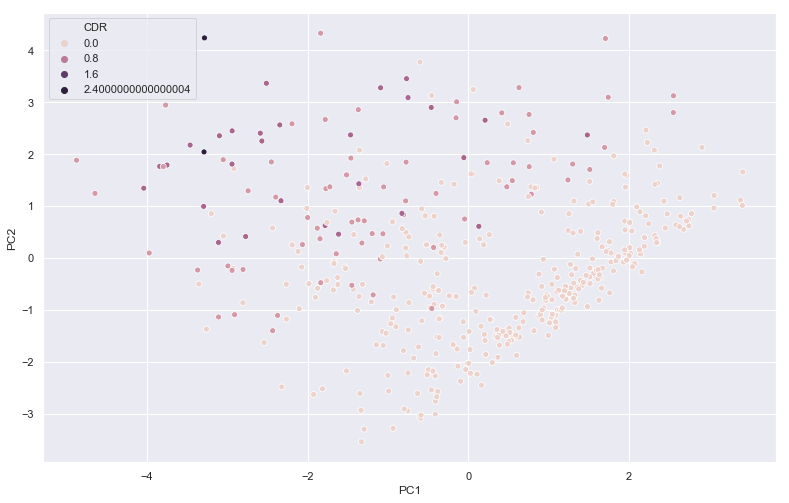

In [75]:
seaborn.set(rc={'figure.figsize':(11.7,8.27)})
ax = seaborn.scatterplot(x="PC1", y="PC2", hue = 'CDR', data=tabularcs)